Todo:
- audio dataset automatic donload with code from kaggle
- make web scraping for text more flexible with names so it won't throw out an error whenever name doesnt match exactly
- do the eda with this rough data to see if it has everything we need for the pipline.
- create new file with buidling pipline so we won't have to rerun eda everytime.

# 1. Imports

## 1.1 Packages

In [1]:
import pandas as pd
import numpy as np
import requests
from selenium import webdriver
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import os
import librosa
import random
import time
import requests
from urllib.parse import unquote

## 1.2 Audio Dataset From kaggle.com

In [2]:
audio_path = "data/audio/original_dataset/"
audio_files = os.listdir(audio_path)
audio_df = pd.DataFrame({
    'model': [os.path.splitext(f)[0] for f in audio_files],
    'path': [os.path.join(audio_path, f) for f in audio_files]
})
print(audio_df.head())

                   model                                               path
0    38sws-dot38-caliber    data/audio/original_dataset/38sws-dot38-caliber
1                  ak-12                  data/audio/original_dataset/ak-12
2                  ak-47                  data/audio/original_dataset/ak-47
3  arctic-warfare-magnum  data/audio/original_dataset/arctic-warfare-magnum
4             beretta-92             data/audio/original_dataset/beretta-92


## 1.3 Image API From wikimedia.org

In [20]:
from image_api import ImageAPI
API_URL = "https://commons.wikimedia.org/w/api.php"
HEADERS = {"User-Agent": "Pipline/1.0 (mkakol.index@gmail.com)"}
audio_files = os.listdir(audio_path)
models = [os.path.splitext(f)[0] for f in audio_files]
image_df = ImageAPI(API_URL, HEADERS).fetch_images_for_models(models)

Searching for 38sws-dot38-caliber...
No image found for 38sws-dot38-caliber.
Searching for ak-12...
Downloaded: https://upload.wikimedia.org/wikipedia/commons/c/c2/5%2C45mm_AK-12_6P70_assault_rifle_at_Military-technical_forum_ARMY-2016_03_noBG.png
Searching for ak-47...
Downloaded: https://upload.wikimedia.org/wikipedia/commons/f/f6/AK-47_assault_rifle.jpg
Searching for arctic-warfare-magnum...
Downloaded: https://upload.wikimedia.org/wikipedia/commons/a/a6/Accuracy_International_AWM_Users.png
Searching for beretta-92...
Downloaded: https://upload.wikimedia.org/wikipedia/commons/2/24/Beretta_92S_%28cropped%29.jpg
Searching for colt-1911...
Downloaded: https://upload.wikimedia.org/wikipedia/commons/c/cf/Colt_M1911_Pistol_from_1912_Army_manual.png
Searching for daewoo-k2...
Downloaded: https://upload.wikimedia.org/wikipedia/commons/5/59/Daewoo_K2_rifle_1.jpg
Searching for desert-eagle...
Downloaded: https://upload.wikimedia.org/wikipedia/commons/8/81/2014-_Desert_Eagle_.50_Action_Express

## 1.4 Web Scraping Text From gunsfandom.com (voorbeeld)

In [ ]:
from text_webscraping import get_fandom_text
url = "https://guns.fandom.com/wiki/AK-47"
paras = get_fandom_text(url)
for i, p in enumerate(paras[:10]):
    print(p)

# 2. EDA

## 2.1 Audio EDA

We nemen de audio dataset als basis, omdat dit als enige meteen als gestructureerde database komt. Elke subfolder is genoemd naar een firearm, wat wij gebruiken als identifier om data te vinden via API of web scraping. Dit is handig omdat we de namen niet handmatig hoeven in te vullen en het vormt een natuurlijke guide voor onze pipeline.

Het audio dataset bevat in totaal 1450 bestanden, verspreid over 58 unieke firearmen. Dit betekent dat voor elke firearm er 25 verschillende audio bestanden beschikbaar zijn, wat ons helpt beter inzicht te krijgen in de variatie van geluiden per wapen. Het doel is om op basis van deze data de feature avg_shots_per_sec te berekenen en te kijken of er correlatie is met de target weapon_type (pistol, rifle, shotgun).

Elke audio sample is 0.5 seconden lang, met een sample rate van 22050 Hz, en de bestandsgrootte is uniform van 43 KB). De dataset is vrij schoon en gestandaardiseerd, waardoor veel preprocessing niet nodig is.

Voor feature engineering trekken we metadata uit de audios: het aantal peaks per sample om avg_shots_per_sec te berekenen en de amplitude van de peaks voor een indicatie van avg_loudness. Signalen bevatten veel ruis, maar meestal overheerst één duidelijke frequentie, waardoor een uitgebreide Fourier-analyse niet nodig is. Gemeten min en peak frequencies liggen tussen 2 en 3844 Hz, wat bruikbaar is voor zowel het tellen van schoten als het beoordelen van het volume.

Audio files: 1450
Unique firearms: 58
Audios per firearm: {'38sws-dot38-caliber': 25, 'ak-12': 25, 'ak-47': 25, 'arctic-warfare-magnum': 25, 'beretta-92': 25, 'colt-1911': 25, 'daewoo-k2': 25, 'desert-eagle': 25, 'double-barrel-shotgun': 25, 'dp-27-lmg': 25, 'fn-p90': 25, 'fn-scar': 25, 'glock': 25, 'glock-18c': 25, 'glock-19-9mm-luger-pistol': 25, 'high-standard-22lr': 25, 'hk-g36c': 25, 'hk-ump45': 25, 'hk-usp-compact-40-sw-pistol': 25, 'kar98k': 25, 'kimber-45acp': 25, 'kriss-vector': 25, 'lorcin-380acp': 25, 'm16': 25, 'm24-sws': 25, 'm249-lmg': 25, 'm4': 25, 'mg42-lmg': 25, 'mini-14': 25, 'mk14-ebr': 25, 'mp-40-40-sw-pistol': 25, 'mp5-smg': 25, 'nagant-m1895': 25, 'ots-14-groza': 25, 'pp-19-bizon': 25, 'pump-action-shotgun': 25, 'qbu-88': 25, 'qbz-95': 25, 'remington-22lr': 25, 'remington-700': 25, 'remington-870': 25, 'rhino-60ds': 25, 'ruger-22lr': 25, 'ruger-357': 25, 'ruger-ar-556': 25, 'saiga-12k': 25, 'sig-p225': 25, 'sks-rifle': 25, 'slr-rifle': 25, 'steyr-aug': 25, 'sw-10-

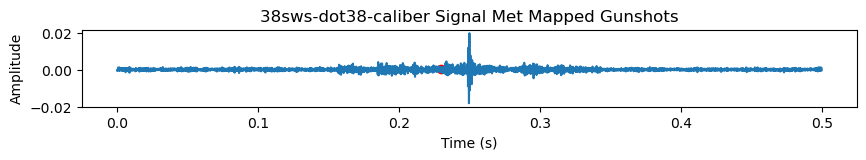

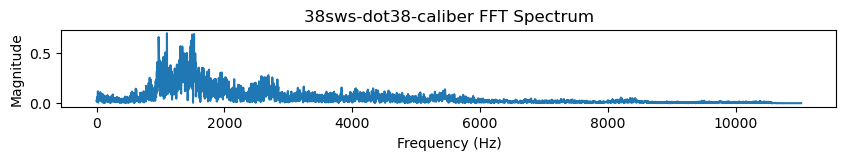

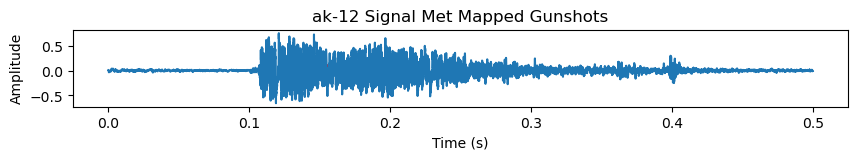

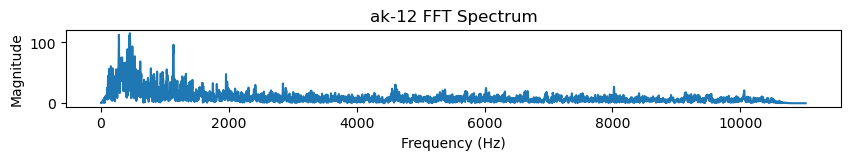

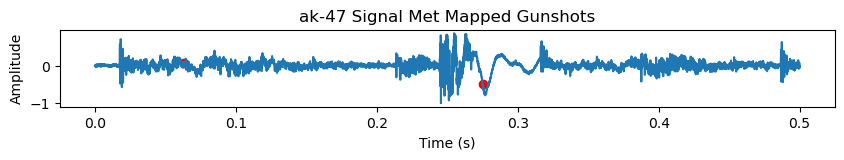

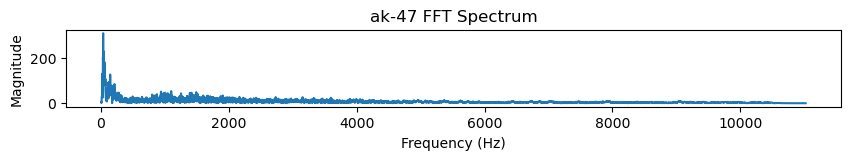

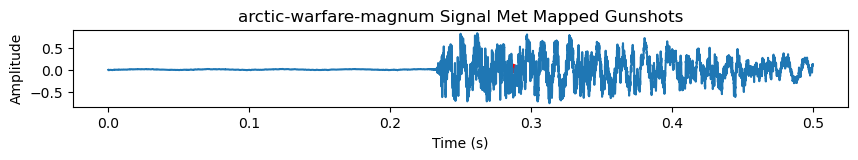

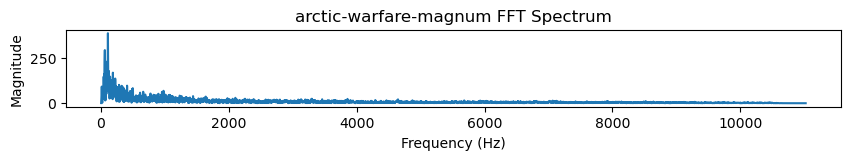

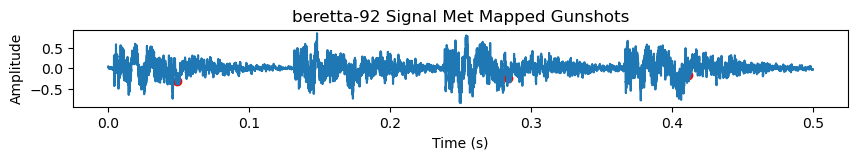

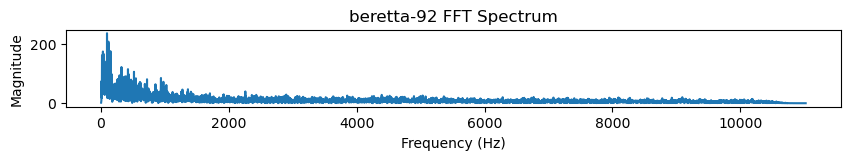

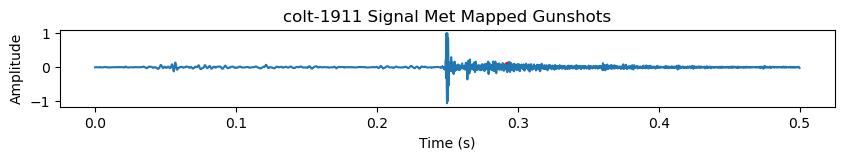

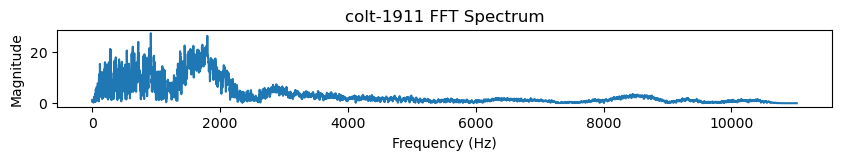

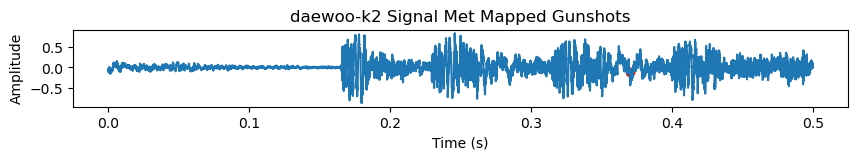

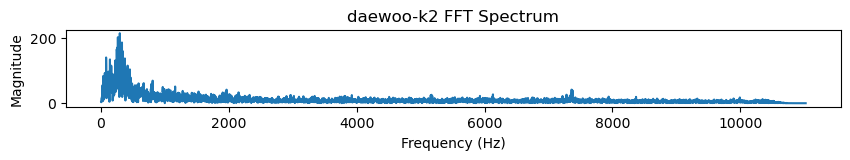

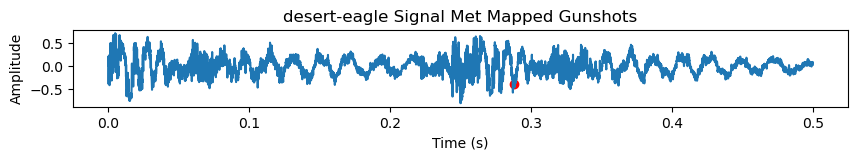

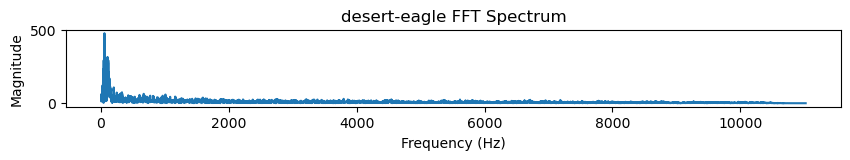

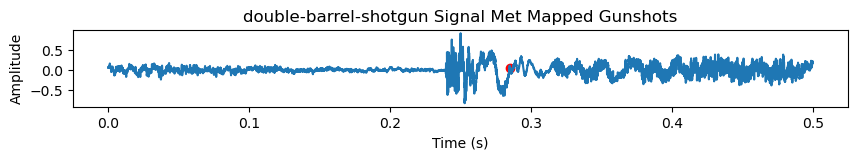

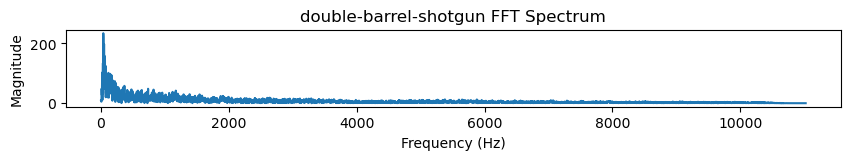

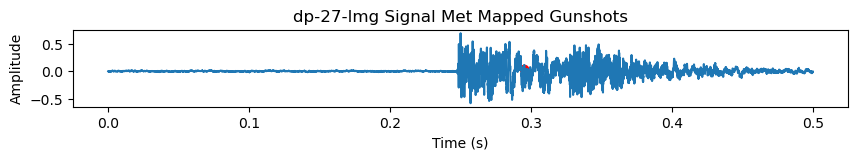

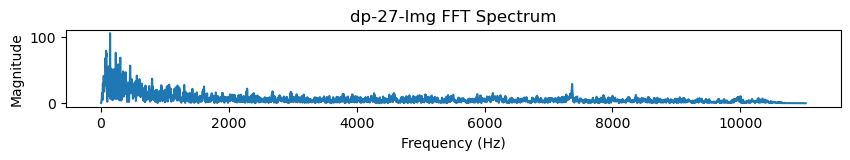

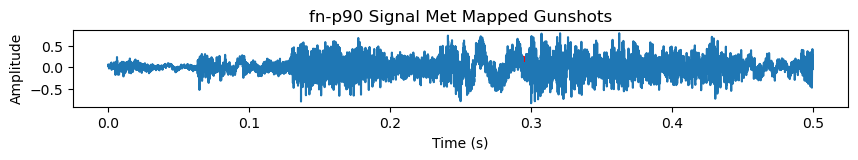

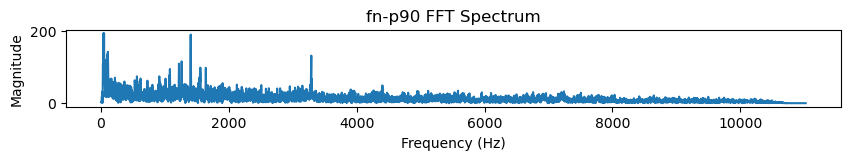

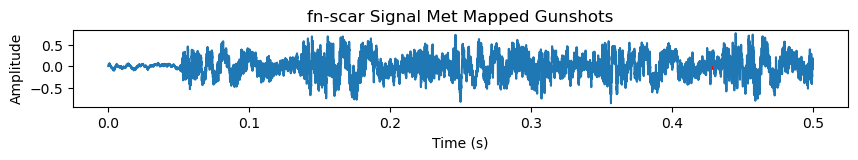

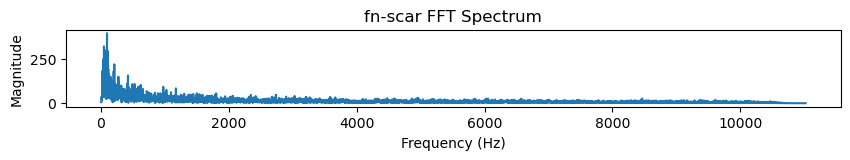

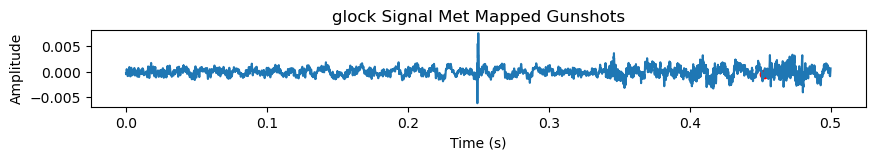

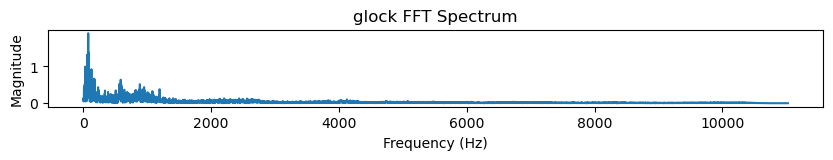

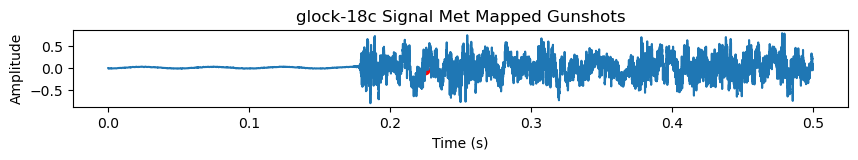

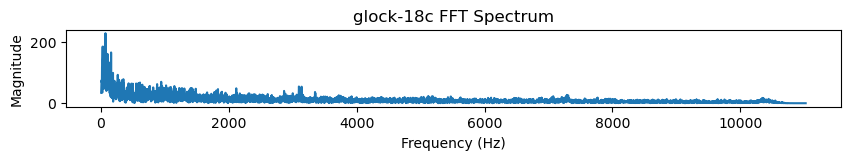

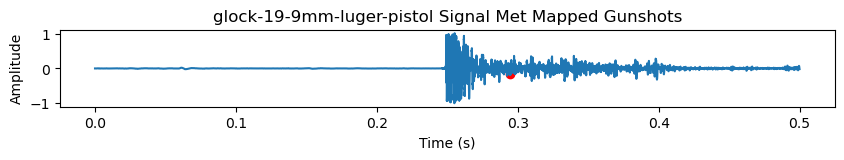

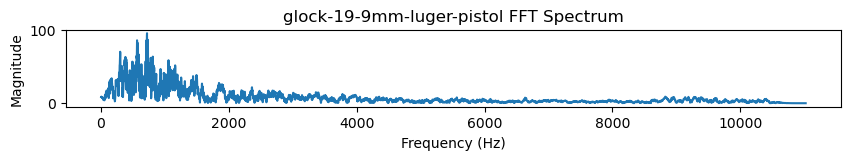

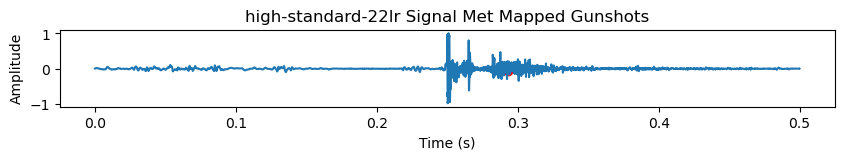

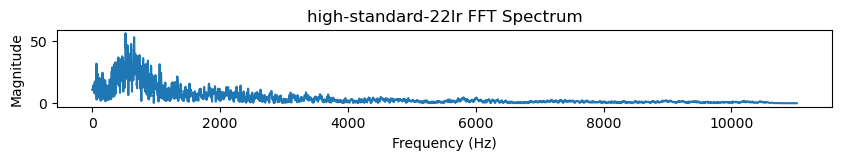

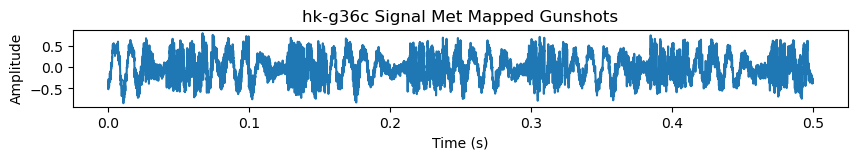

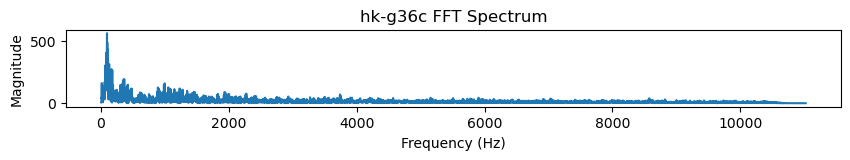

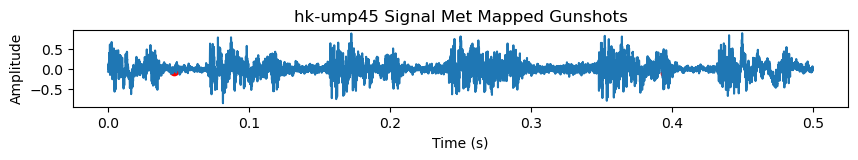

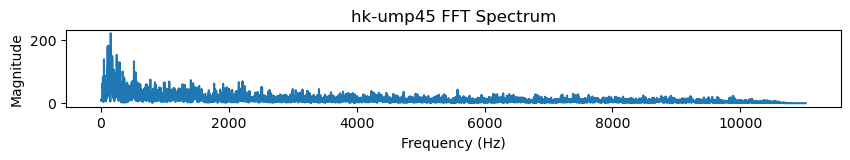

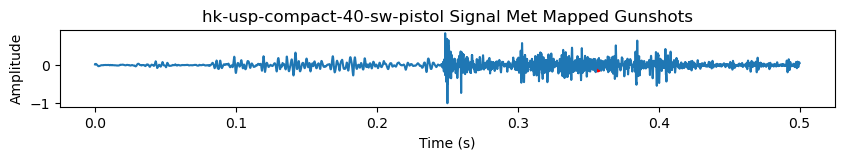

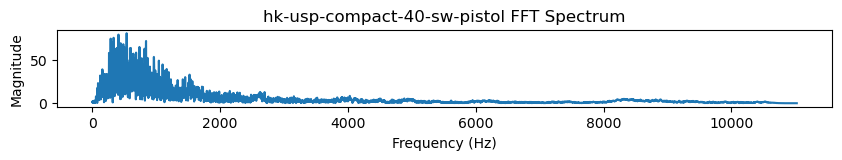

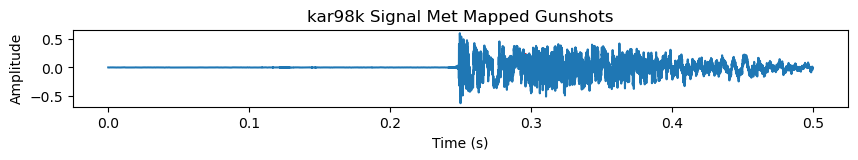

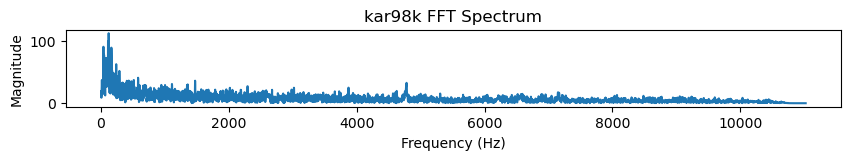

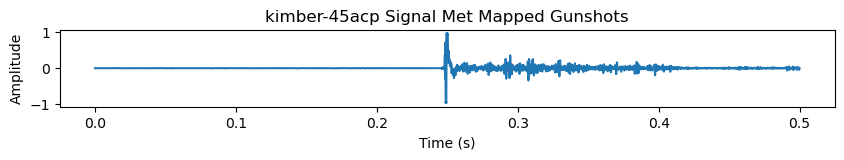

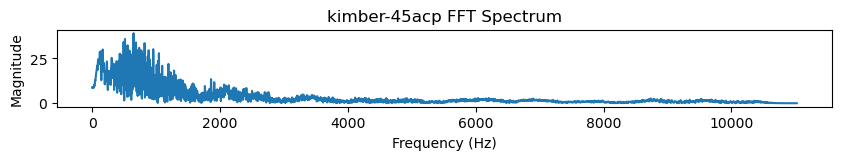

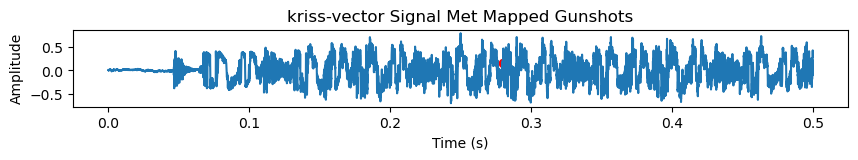

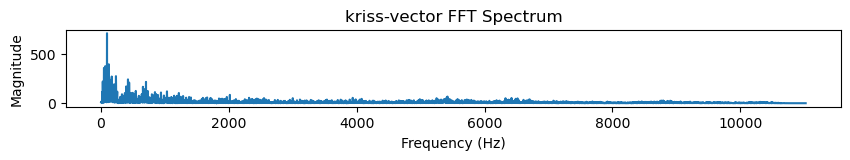

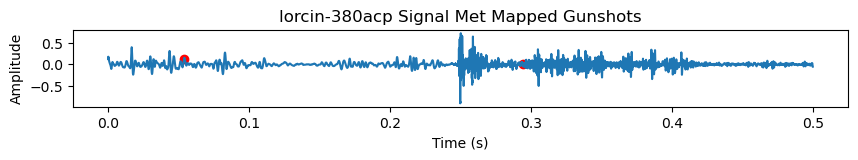

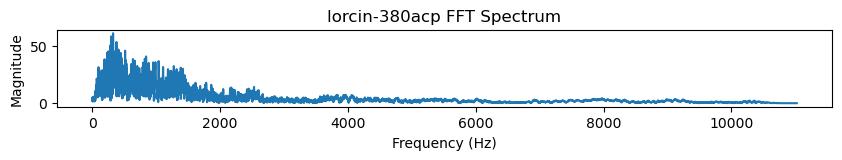

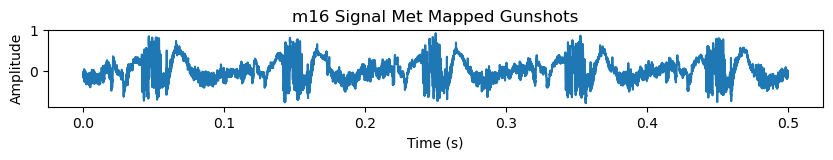

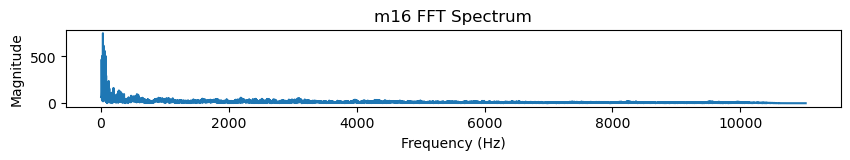

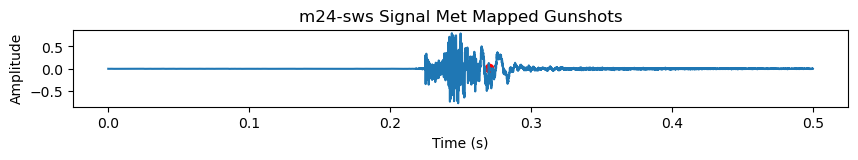

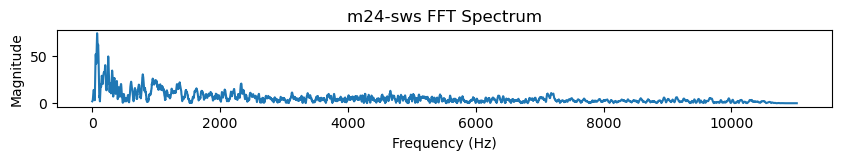

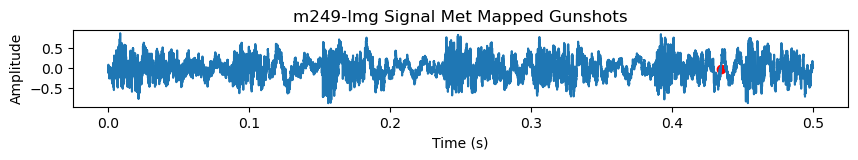

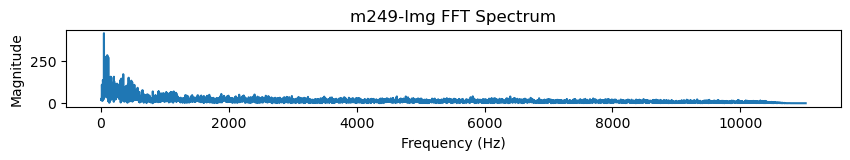

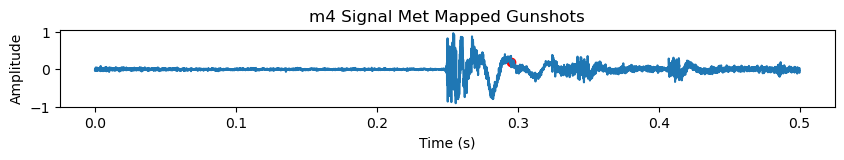

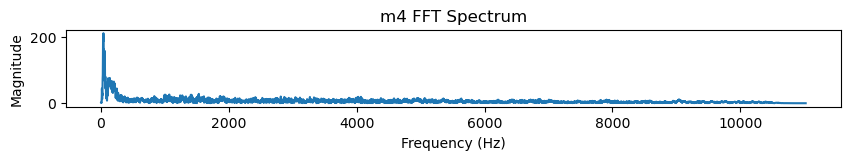

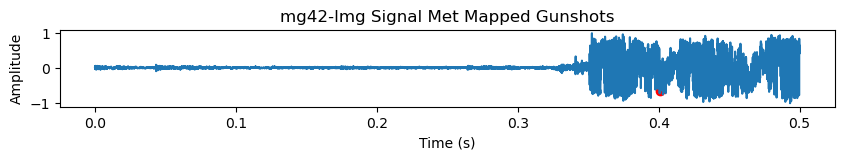

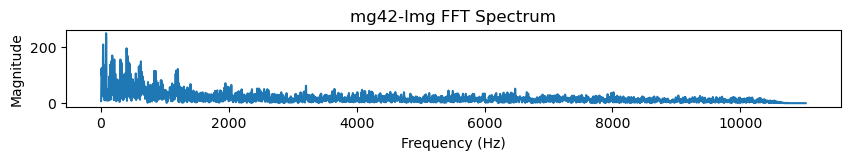

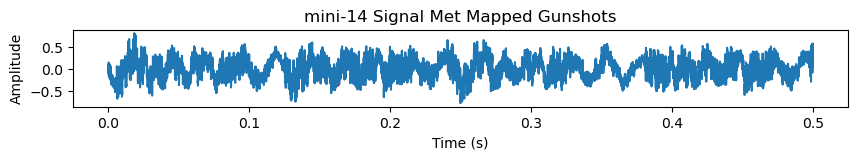

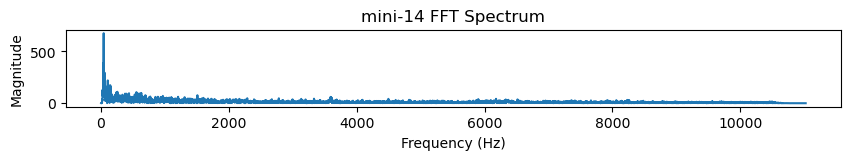

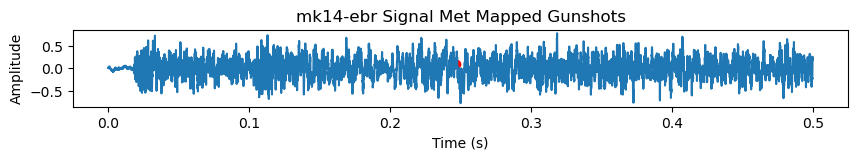

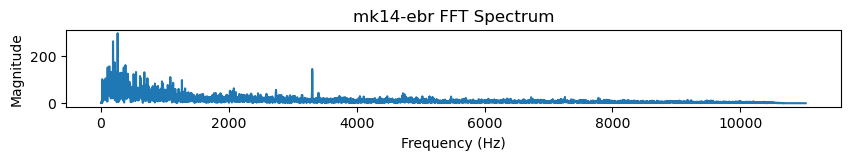

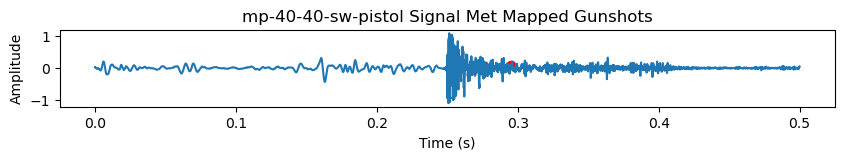

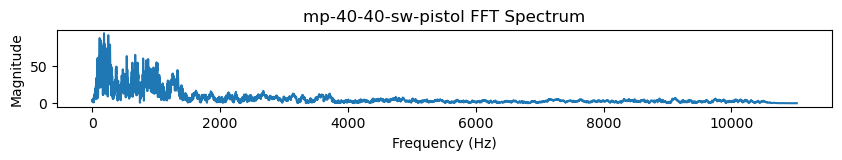

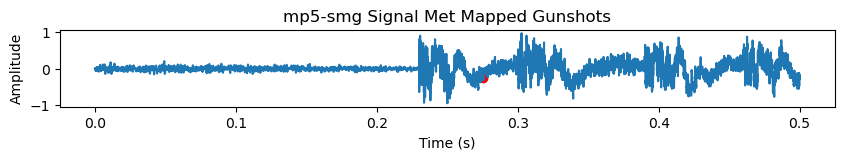

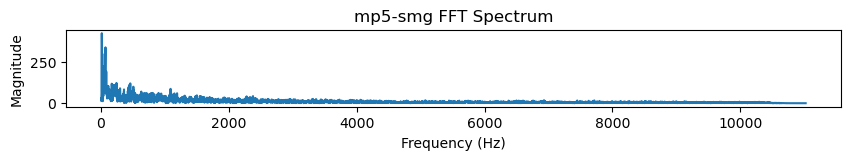

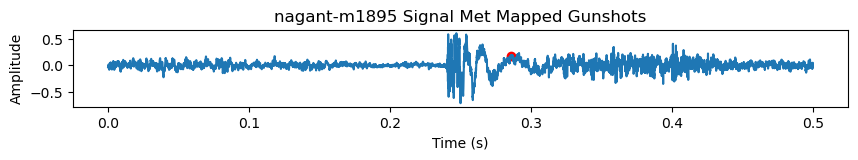

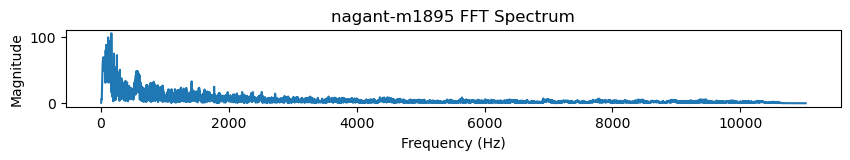

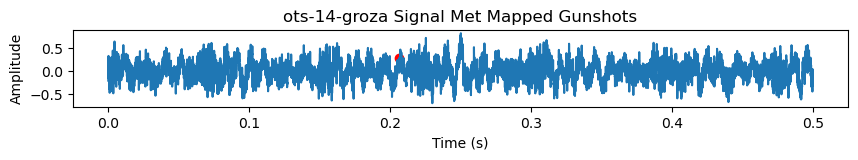

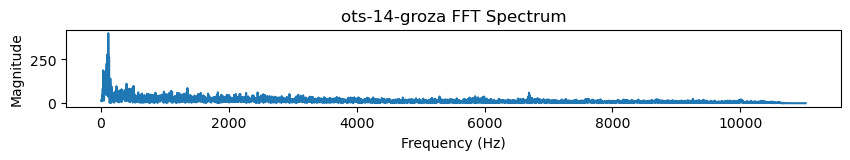

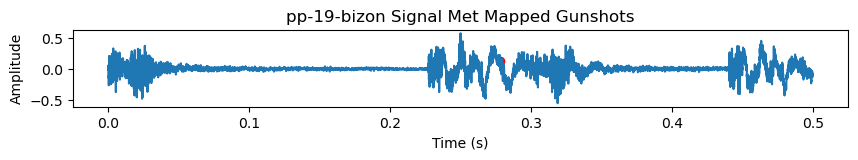

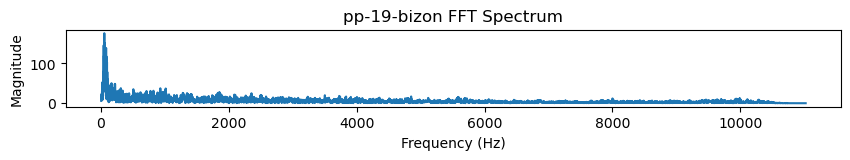

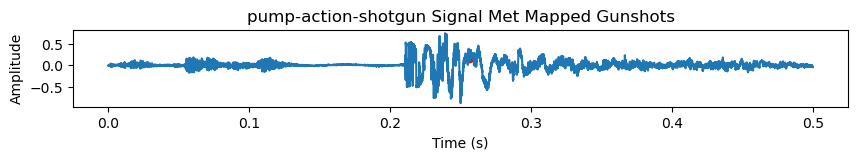

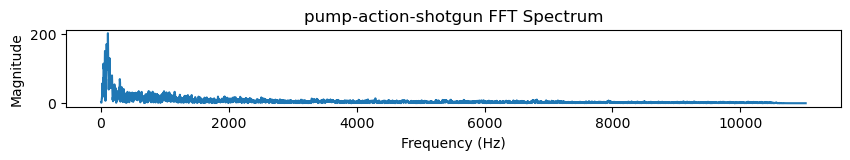

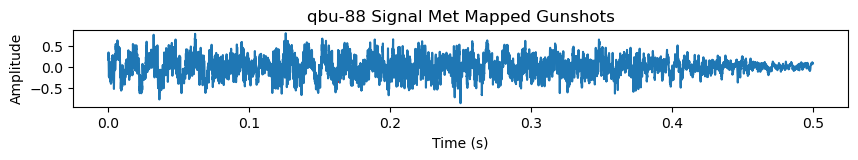

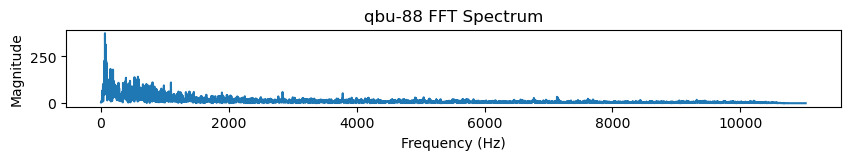

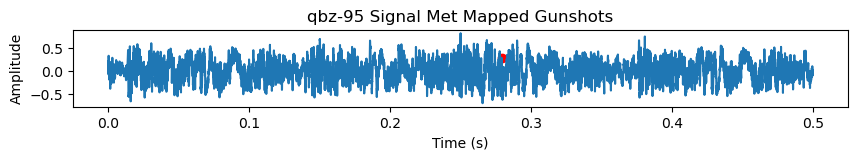

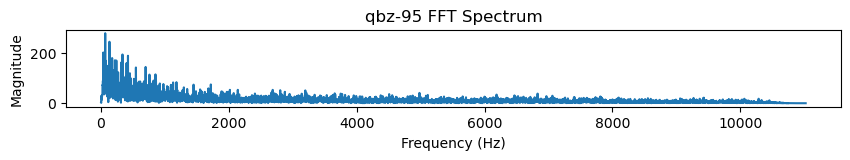

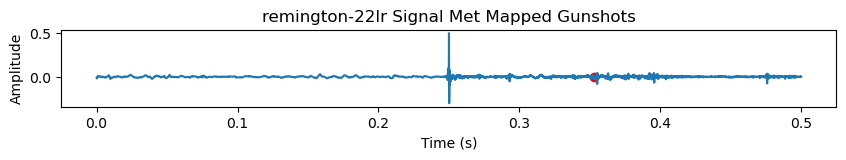

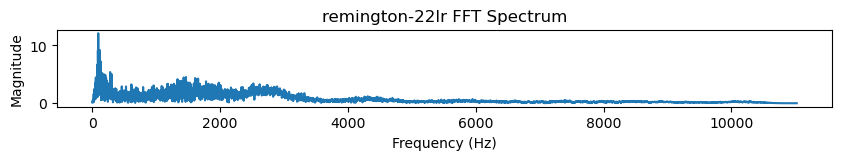

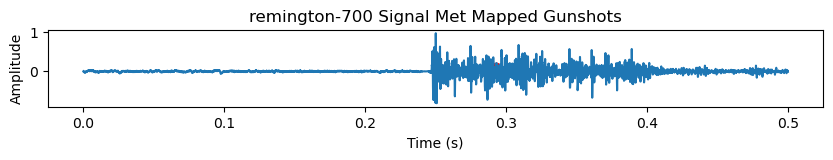

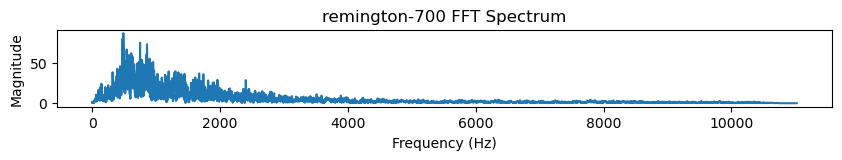

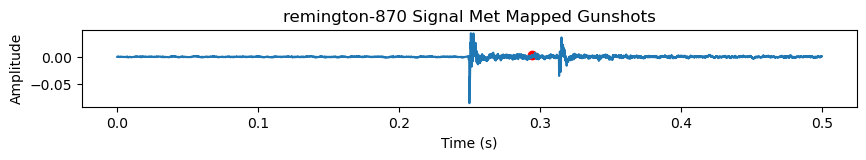

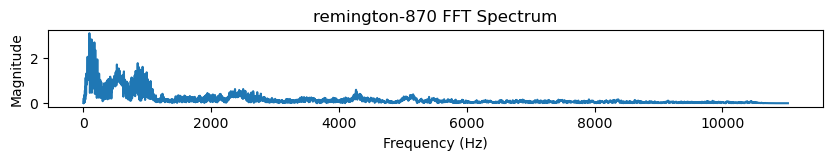

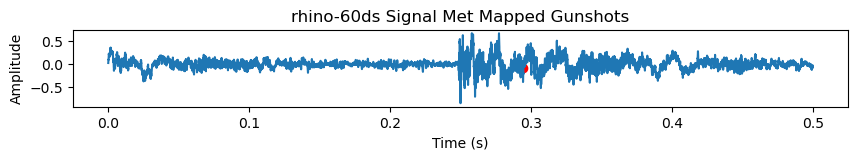

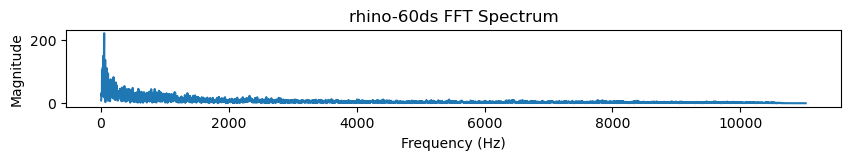

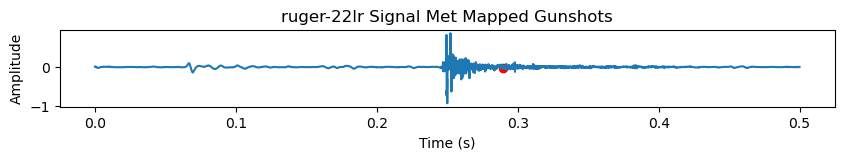

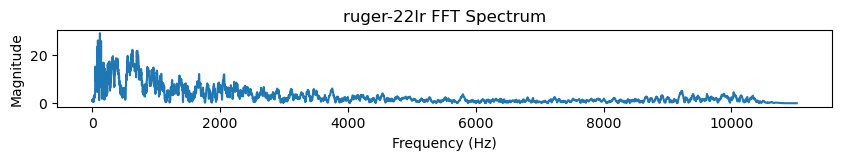

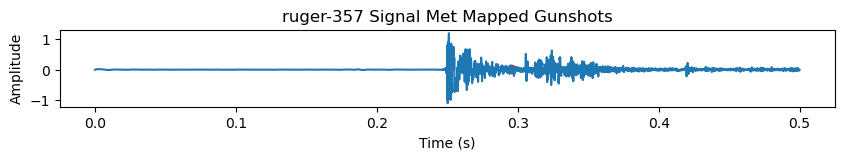

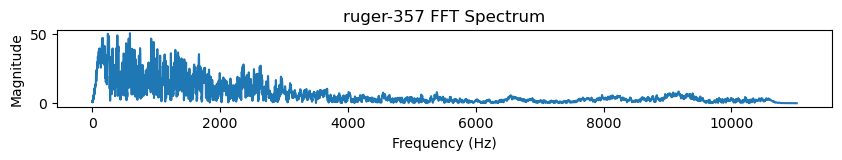

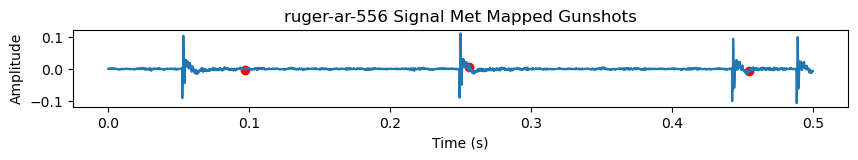

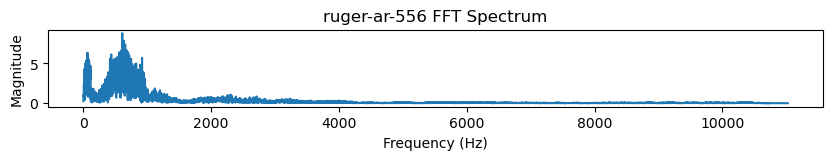

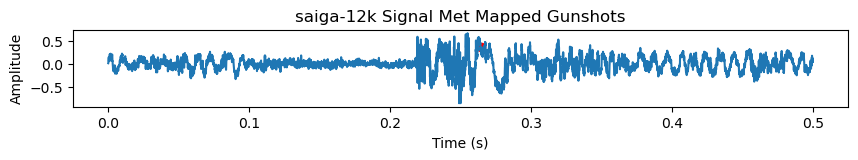

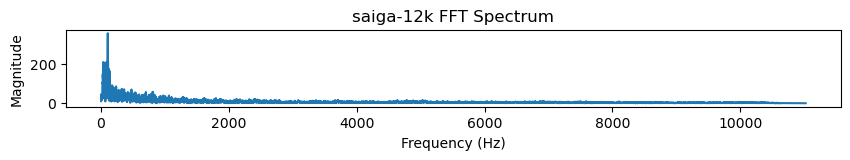

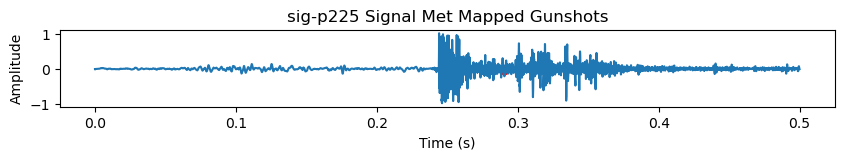

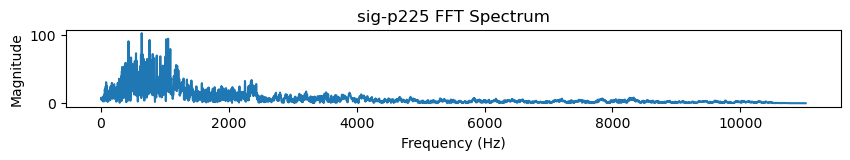

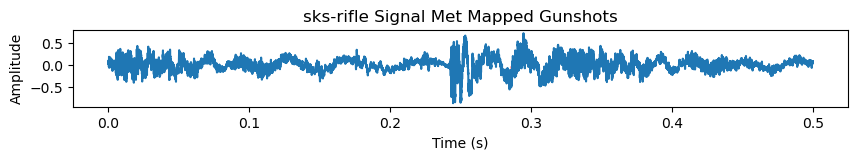

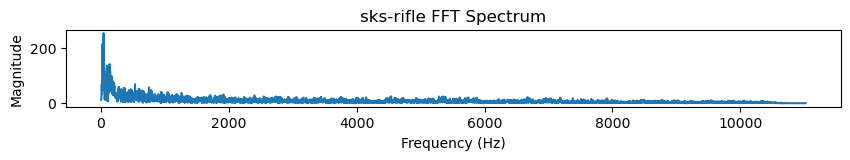

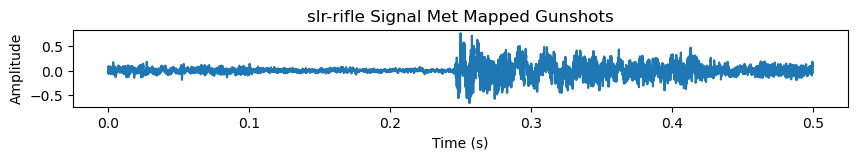

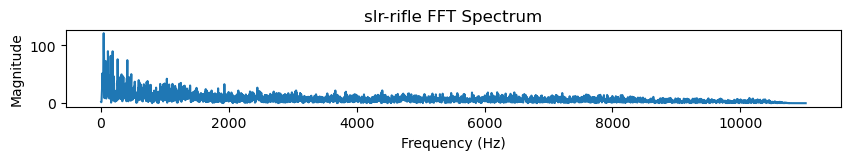

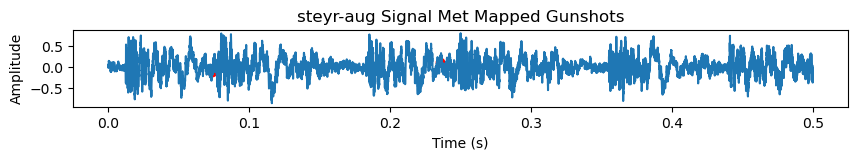

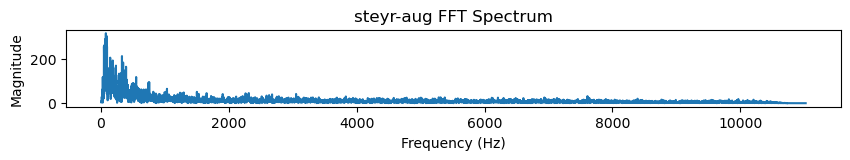

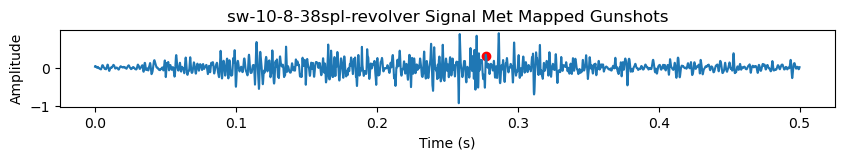

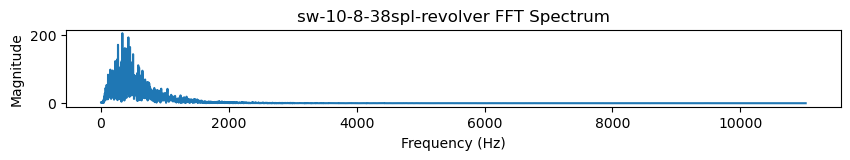

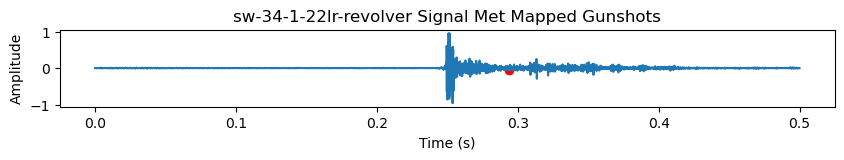

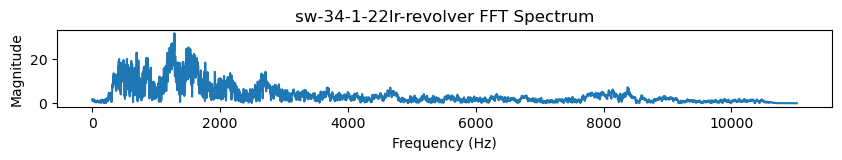

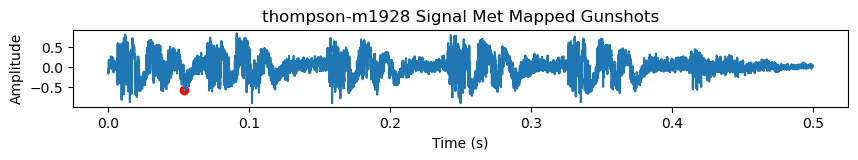

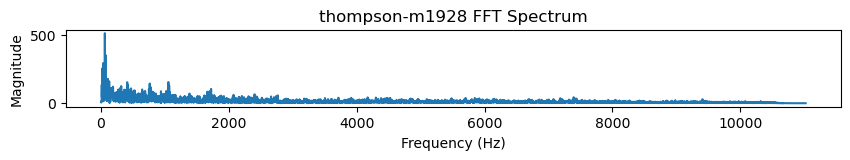

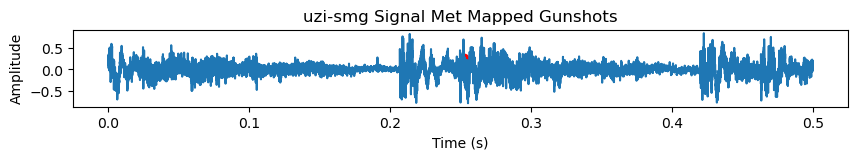

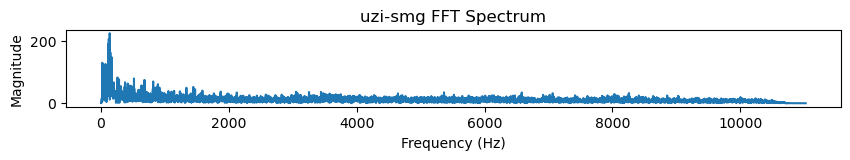

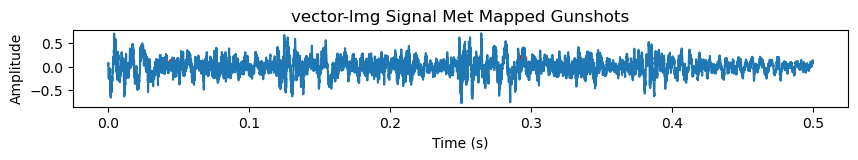

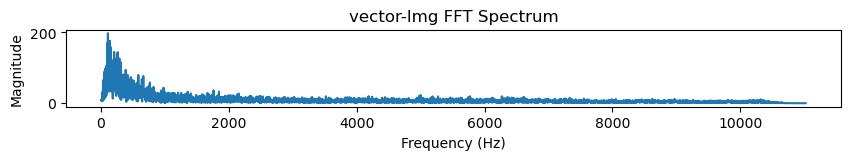

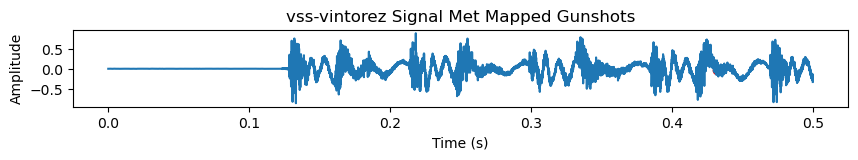

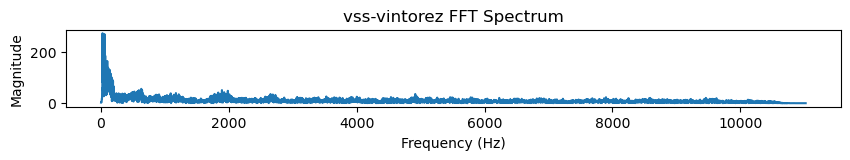

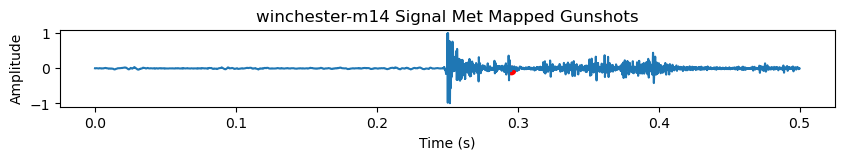

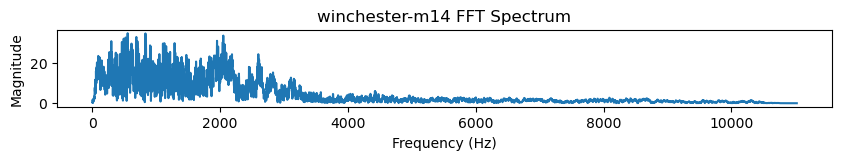

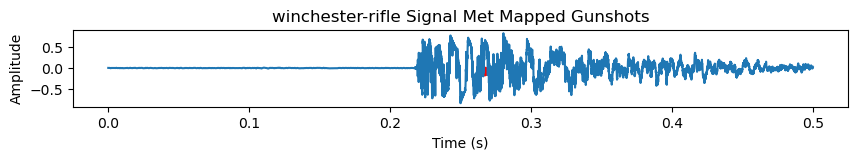

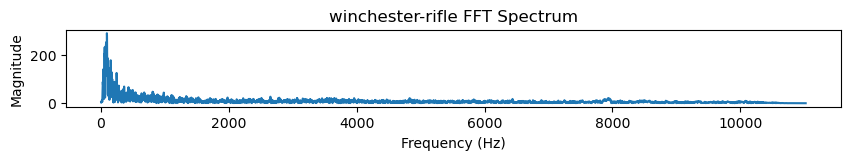

               firearm                                           filename  \
0  38sws-dot38-caliber  38sws-dot38-caliber_001_4a48b77c-72bf-4917-b8b...   
1  38sws-dot38-caliber  38sws-dot38-caliber_002_3ab0f1bb-f7fe-4cfe-a78...   
2  38sws-dot38-caliber  38sws-dot38-caliber_003_090f69a9-885c-45fb-a80...   
3  38sws-dot38-caliber  38sws-dot38-caliber_004_907b513b-dd5e-4756-a20...   
4  38sws-dot38-caliber  38sws-dot38-caliber_005_a7973dd2-b255-4711-9f9...   

                                                path  
0  data/audio/original_dataset\38sws-dot38-calibe...  
1  data/audio/original_dataset\38sws-dot38-calibe...  
2  data/audio/original_dataset\38sws-dot38-calibe...  
3  data/audio/original_dataset\38sws-dot38-calibe...  
4  data/audio/original_dataset\38sws-dot38-calibe...  


In [3]:
from audio_dataset import audio_eda
audio_df, counts, dur, srates, peak_freqs = audio_eda("data/audio/original_dataset")
print(audio_df.head())

## 2.2 Image EDA

## 2.3 Text EDA

In [30]:
# TESTING
import pandas as pd
import time

def scrape_firearm_descriptions(audio_df):
    base_url = "https://guns.fandom.com/wiki/"
    descriptions = []

    for model in audio_df['firearm']:
        # Build URL based on firearm model name
        search_term = model.replace(" ", "_").replace("-", "_")
        url = base_url + search_term

        # Get HTML
        response = requests.get(url)
        soup = BeautifulSoup(response.content, "html.parser")

        # Get main paragraph text
        paragraphs = soup.find_all("p")
        text = " ".join([p.get_text(strip=True) for p in paragraphs[:2]])  # first 2 paragraphs

        descriptions.append({
            "firearm": model,
            "url": url,
            "description": text
        })
        time.sleep(1)

    return pd.DataFrame(descriptions)
text_df = scrape_firearm_descriptions(audio_df)
display(text_df.head())


                 firearm  avg_shots_per_sec  avg_peak_amplitude
0    38sws-dot38-caliber              17.92            0.495045
1                  ak-12              52.88            0.822629
2                  ak-47              45.36            0.880013
3  arctic-warfare-magnum              81.44            0.863700
4             beretta-92              46.56            0.812460


# 3 Preprocessing

## 3.1 Audio Preprocessing

Values for the function need to be aangepast as they dont exactly overlap with the shots fired

In [4]:
from audio_dataset import extract_avg_features
audio_path = "data/audio/original_dataset/"
firearm_features = extract_avg_features(audio_path)
print(firearm_features.head())

                 firearm  avg_shots_per_sec  avg_peak_amplitude
0    38sws-dot38-caliber               2.64            0.495045
1                  ak-12               2.72            0.822629
2                  ak-47               3.92            0.880013
3  arctic-warfare-magnum               2.00            0.863700
4             beretta-92               5.36            0.812460


## 3.2 Image Preprocessing

## 3.3 Text Preprocessing

In [ ]:
# TESTING
import requests
from bs4 import BeautifulSoup

URL = "https://guns.fandom.com/wiki/Remington_Model_597"
HEADERS = {"User-Agent": "Mozilla/5.0 (compatible; scraping-test/1.0; +mailto:mkakol.index@gmail.com)"}

resp = requests.get(URL, headers=HEADERS, timeout=10)
print("HTTP status:", resp.status_code)
if resp.status_code != 200:
    raise SystemExit("Non-200 response — check status / headers / possible blocking")

soup = BeautifulSoup(resp.content, "lxml")

# Approach: find the heading text "Weapon type" (it's an <h3> or <strong> on some pages)
label = soup.find(lambda tag: tag.name in ("h3","h4","th","strong") and "Weapon type" in tag.get_text())
print("Label found:", bool(label), "tag:", getattr(label, "name", None))
if label:
    # weapon type value is often the next tag (or next sibling)
    # try several sensible moves:
    candidate = label.find_next()
    # find next <a> after label
    weapon_a = label.find_next("a")
    if weapon_a:
        print("Weapon type text:", weapon_a.get_text(strip=True))
        print("Weapon type href:", weapon_a.get("href"))
    else:
        print("No <a> found after label, showing next text:", candidate.get_text(strip=True) if candidate else None)
else:
    # fallback debugging
    snippet = resp.content.decode("utf-8", errors="replace")[:2000]
    print("Could not find 'Weapon type' label. HTML snippet (first 2000 chars):")
    print(snippet)